# Setup and Imports

In [48]:
import pandas as pd
import numpy as np
import london_data_functions as ldf
import warnings
import seaborn as sns
sns.set
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

import xgboost
import pickle
from sklearn.model_selection import ParameterSampler
from scipy import sparse

# Get the Data

In [2]:
%%time
query = """
            SELECT incident_number, timestamp_of_call, incident_group, property_category, 
                    property_type, address_qualifier, borough_name, ward_name, 
                    first_pump_arriving_attendance_time as first_time, first_pump_arriving_deployed_from_station as first_station,
                    num_stations_with_pumps_attending as station_pumps, num_pumps_attending as pumps_attending,
                    FROM `gdac-327115.LondonFire.fire_brigade`
        """

london = ldf.fetch_london_data(query_string=query, project_id = "gdac-327115", location = "eu")

Wall time: 8.21 s


# Split the Data into Training and Test Sets

In [3]:
london_train, london_test = train_test_split(london, test_size = .16, stratify = london["incident_group"], random_state = 42)

# Clean the Training Data

In [4]:
warnings.filterwarnings('ignore')
london_train = ldf.clean_london(london_train)

Cleaning London Data Started...

Sucessfully Added Emergency Column!
Sucessfully Added Month Column!
Sucessfully Added Hour Column!
Sucessfully Cleanded Property Category!
Sucessfully Cleaned and Ranked Property Type!
Sucessfully Cleaned Address!
Sucessfully Cleaned Borough Names!
Sucessfully Cleaned and Ranked Ward Names!
Sucessfully Imputed Station Names!
Sucessfully Ranked Stations!
Sucessfully Cleaned Station Arriving Time!
Sucessfully Cleaned Number of Stations with Pumps!
Sucessfully Cleaned Number of Pumps Attending!
Sucessfully Dropped Unecessary Columns!

Sucessfully Cleaned London Data!


In [30]:
london_train.dtypes

property_category     object
address_qualifier     object
borough_name          object
first_time           float64
station_pumps         object
pumps_attending       object
Emergency              int64
Month                 object
Hour                  object
pt_rank               object
wn_rank               object
stat_rank             object
dtype: object

# Prepare the Data

In [5]:
def prepare_london(df, cat_attribs, num_attribs, target):
    """
    
    """
    #num_pipeline = Pipeline(["std_scaler", StandardScaler()])
    cat_encoder = OneHotEncoder()
    
    full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
    
    X = full_pipeline.fit_transform(df)
    y = np.array(df[target])
    
    return X, y
    

In [6]:
cat_vars = ["property_category", "address_qualifier", "borough_name", "station_pumps", "pumps_attending", "Month", 
            "Hour", "pt_rank", "wn_rank", "stat_rank"]
num_vars = ["first_time"]
target = "Emergency"
X, y = prepare_london(london_train, cat_vars, num_vars, target)

In [7]:
print(X.shape)
print(y.shape)

(26719, 109)
(26719,)


In [36]:
feature_dim = 0

for feature in london_train[cat_vars].columns:
    feature_dim += len(london_train[feature].unique())
    
feature_dim += 1

print(feature_dim)

109


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .10, stratify = y, random_state = 42)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(24047, 109)
(2672, 109)
(24047,)
(2672,)


# Baseline Scores

### Logistic Regression

In [30]:
log_reg = LogisticRegression(max_iter = 10000)

In [31]:
%%time
y_train_pred = cross_val_predict(log_reg, X_train, y_train, cv = 5)
lr_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
lr_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
lr_cv_rec = np.round(recall_score(y_train, y_train_pred), 4) * 100
print(f'Logistic Regression 5-fold CV Baseline F1-Score: {lr_cv_f1:.2f}%')
print(f'Logistic Regression 5-fold CV Baseline Recall: {lr_cv_rec:.2f}%')
print(f'Logistic Regression 5-fold CV Baseline Accuracy: {lr_cv_acc:.2f}%')

Logistic Regression 5-fold CV Baseline F1-Score: 81.29%
Logistic Regression 5-fold CV Baseline Recall: 79.05%
Logistic Regression 5-fold CV Baseline Accuracy: 81.43%
Wall time: 2.28 s


In [32]:
confusion_matrix(y_train, y_train_pred)

array([[9877, 1895],
       [2571, 9704]], dtype=int64)

### Bayesian Regression

In [33]:
br_reg = BayesianRidge()

In [34]:
%%time
y_train_pred = cross_val_predict(br_reg, X_train.toarray(), y_train, cv = 5)
y_train_pred = np.round(y_train_pred)
br_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
br_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
br_cv_rec = np.round(recall_score(y_train, y_train_pred), 4) * 100
print(f'Bayesian Regression 5-fold CV Baseline F1-Score: {br_cv_f1:.2f}%')
print(f'Bayesian Regression 5-fold CV Baseline Recall: {br_cv_rec:.2f}%')
print(f'Bayesian Regression 5-fold CV Baseline Accuracy: {br_cv_acc:.2f}%')

Bayesian Regression 5-fold CV Baseline F1-Score: 81.24%
Bayesian Regression 5-fold CV Baseline Recall: 79.20%
Bayesian Regression 5-fold CV Baseline Accuracy: 81.32%
Wall time: 1.13 s


In [35]:
confusion_matrix(y_train, y_train_pred)

array([[9834, 1938],
       [2553, 9722]], dtype=int64)

### Naive Bayes

In [36]:
nb_clf = GaussianNB()

In [37]:
%%time
y_train_pred = cross_val_predict(nb_clf, X_train.toarray(), y_train, cv = 5)
nb_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
nb_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
nb_cv_rec = np.round(recall_score(y_train, y_train_pred), 4) * 100
print(f'Naive Bayes 5-fold CV Baseline F1-Score: {nb_cv_f1:.2f}%')
print(f'Naive Bayes 5-fold CV Baseline Recall: {nb_cv_rec:.2f}%')
print(f'Naive Bayes 5-fold CV Baseline Accuracy: {nb_cv_acc:.2f}%')

Naive Bayes 5-fold CV Baseline F1-Score: 76.09%
Naive Bayes 5-fold CV Baseline Recall: 76.69%
Naive Bayes 5-fold CV Baseline Accuracy: 75.40%
Wall time: 370 ms


In [38]:
confusion_matrix(y_train, y_train_pred)

array([[8717, 3055],
       [2861, 9414]], dtype=int64)

### Linear SVC

In [39]:
svc_clf = LinearSVC()

In [40]:
%%time
y_train_pred = cross_val_predict(svc_clf, X_train, y_train, cv = 5)
svc_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
svc_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
svc_cv_rec = np.round(recall_score(y_train, y_train_pred), 4) * 100
print(f'Linear SVC 5-fold CV Baseline F1-Score: {svc_cv_f1:.2f}%')
print(f'Linear SVC 5-fold CV Baseline Recall: {svc_cv_rec:.2f}%')
print(f'Linear SVC 5-fold CV Baseline Accuracy: {svc_cv_acc:.2f}%')

Linear SVC 5-fold CV Baseline F1-Score: 81.23%
Linear SVC 5-fold CV Baseline Recall: 78.86%
Linear SVC 5-fold CV Baseline Accuracy: 81.39%
Wall time: 6.73 s


In [41]:
confusion_matrix(y_train, y_train_pred)

array([[9892, 1880],
       [2595, 9680]], dtype=int64)

### Random Forest

In [12]:
rf_clf = RandomForestClassifier()

In [14]:
%%time
y_train_pred = cross_val_predict(rf_clf, X_train.toarray(), y_train, cv = 5)
rf_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
rf_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
rf_cv_rec = np.round(recall_score(y_train, y_train_pred), 4) * 100
print(f'Random Forest 5-fold CV Baseline F1-Score: {rf_cv_f1:.2f}%')
print(f'Random Forest 5-fold CV Baseline Recall: {rf_cv_rec:.2f}%')
print(f'Random Forest 5-fold CV Baseline Accuracy: {rf_cv_acc:.2f}%')

Random Forest 5-fold CV Baseline F1-Score: 82.02%
Random Forest 5-fold CV Baseline Recall: 79.68%
Random Forest 5-fold CV Baseline Accuracy: 82.17%
Wall time: 18.8 s


In [15]:
confusion_matrix(y_train, y_train_pred)

array([[9978, 1794],
       [2494, 9781]], dtype=int64)

### Extremely Random Trees

In [16]:
er_clf = ExtraTreesClassifier()

In [17]:
%%time
y_train_pred = cross_val_predict(er_clf, X_train.toarray(), y_train, cv = 5)
er_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
er_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
er_cv_rec = np.round(recall_score(y_train, y_train_pred), 4) * 100
print(f'Extremely Random Trees 5-fold CV Baseline F1-Score: {er_cv_f1:.2f}%')
print(f'Extremely Random Trees 5-fold CV Baseline Recall: {er_cv_rec:.2f}%')
print(f'Extremely Random Treess 5-fold CV Baseline Accuracy: {er_cv_acc:.2f}%')

Extremely Random Trees 5-fold CV Baseline F1-Score: 81.10%
Extremely Random Trees 5-fold CV Baseline Recall: 79.72%
Extremely Random Treess 5-fold CV Baseline Accuracy: 81.04%
Wall time: 25.6 s


In [18]:
confusion_matrix(y_train, y_train_pred)

array([[9701, 2071],
       [2489, 9786]], dtype=int64)

### AdaBoost

In [21]:
ada_clf = AdaBoostClassifier()

In [24]:
%%time
y_train_pred = cross_val_predict(ada_clf, X_train.toarray(), y_train, cv = 5)
ada_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
ada_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
ada_cv_rec = np.round(recall_score(y_train, y_train_pred), 4) * 100
print(f'AdaBoost 5-fold CV Baseline F1-Score: {ada_cv_f1:.2f}%')
print(f'AdaBoost 5-fold CV Baseline Recall: {ada_cv_rec:.2f}%')
print(f'AdaBoost 5-fold CV Baseline Accuracy: {ada_cv_acc:.2f}%')

AdaBoost 5-fold CV Baseline F1-Score: 80.99%
AdaBoost 5-fold CV Baseline Recall: 80.19%
AdaBoost 5-fold CV Baseline Accuracy: 80.78%
Wall time: 15.7 s


In [25]:
confusion_matrix(y_train, y_train_pred)

array([[9583, 2189],
       [2432, 9843]], dtype=int64)

### XGBoost

In [26]:
xgb_clf = xgboost.XGBClassifier(use_label_encoder=False, objective = "binary:logistic")

In [28]:
%%time
y_train_pred = cross_val_predict(xgb_clf, X_train, y_train, cv = 5)
xgb_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
xgb_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
xgb_cv_rec = np.round(recall_score(y_train, y_train_pred), 4) * 100
print(f'XGBoost 5-fold CV Baseline F1-Score: {xgb_cv_f1:.2f}%')
print(f'XGBoost 5-fold CV Baseline Recall: {xgb_cv_rec:.2f}%')
print(f'XGBoost 5-fold CV Baseline Accuracy: {xgb_cv_acc:.2f}%')

[15:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [29]:
confusion_matrix(y_train, y_train_pred)

array([[9976, 1796],
       [2433, 9842]], dtype=int64)

# Baseline Results

## Recall

In [52]:
Models = ["Logistic Regression", "Bayesian Regression", "Naive Bayes", "Linear SVC", "Random Forest",
          "Extreme Trees", "AdaBoost", "XGBoost"]
Recall_Base_Scores = [lr_cv_rec, br_cv_rec, nb_cv_rec, svc_cv_rec, rf_cv_rec, er_cv_rec, ada_cv_rec, xgb_cv_rec]
Accuracy_Base_Scores = [lr_cv_acc, br_cv_acc, nb_cv_acc, svc_cv_acc, rf_cv_acc, er_cv_acc, ada_cv_acc, xgb_cv_acc]

#Create a data frame with the results
base_results = pd.DataFrame({"Model": Models, "Recall": Recall_Base_Scores, "Accuracy" : Accuracy_Base_Scores})

In [53]:
base_results.sort_values(by="Recall", ascending = False, inplace = True)
base_results

,Model,Recall,Accuracy
6,AdaBoost,80.19,80.78
7,XGBoost,80.18,82.41
5,Extreme Trees,79.72,81.04
4,Random Forest,79.68,82.17
1,Bayesian Regression,79.20,81.32
0,Logistic Regression,79.05,81.43
3,Linear SVC,78.86,81.39
2,Naive Bayes,76.69,75.40


Text(0.5, 0, 'Models')

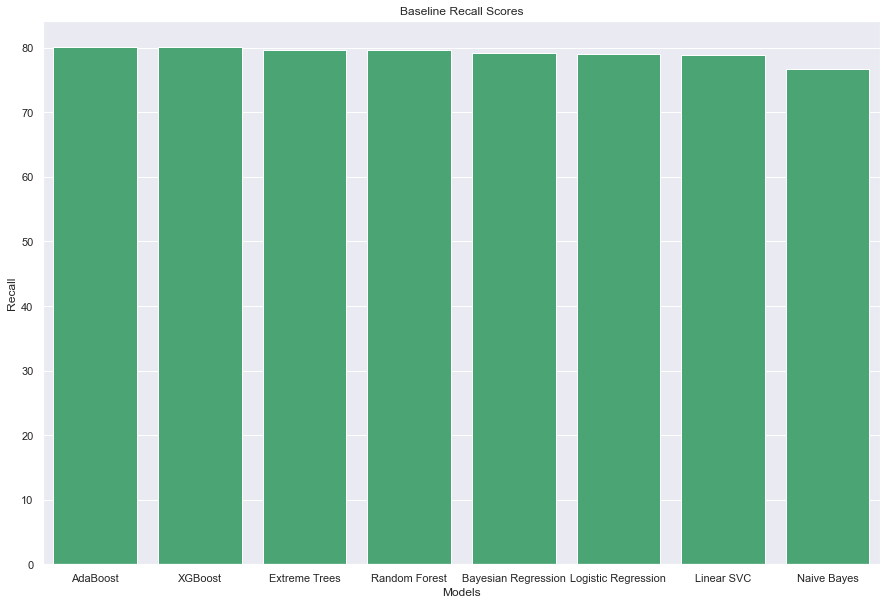

In [54]:
#Bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Model", y = "Recall", order = base_results["Model"] \
                                            , data = base_results, color = "mediumseagreen")
plt.title("Baseline Recall Scores")
plt.ylabel("Recall")
plt.xlabel("Models")

## Accuracy

In [55]:
base_results.sort_values(by="Accuracy", ascending = False, inplace = True)
base_results

,Model,Recall,Accuracy
7,XGBoost,80.18,82.41
4,Random Forest,79.68,82.17
0,Logistic Regression,79.05,81.43
3,Linear SVC,78.86,81.39
1,Bayesian Regression,79.20,81.32
5,Extreme Trees,79.72,81.04
6,AdaBoost,80.19,80.78
2,Naive Bayes,76.69,75.40


Text(0.5, 0, 'Models')

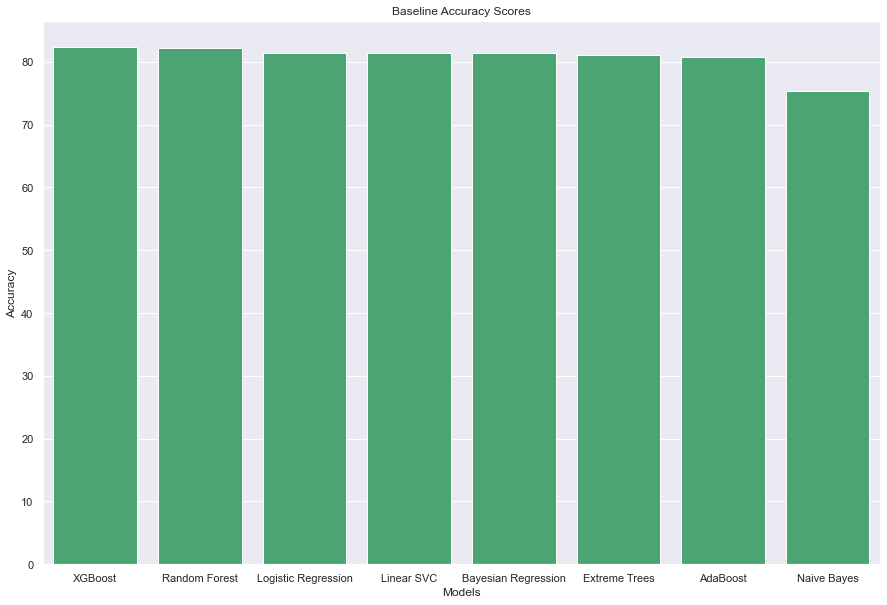

In [56]:
#Bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Model", y = "Accuracy", order = base_results["Model"] \
                                            , data = base_results, color = "mediumseagreen")
plt.title("Baseline Accuracy Scores")
plt.ylabel("Accuracy")
plt.xlabel("Models")

# Hyperparameter Tuning

### Logistic Regression

In [60]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "C" : np.linspace(0, 30, 10000),
    }
lr_clf = LogisticRegression(penalty = "l2", solver = "lbfgs", max_iter=10000)

lr_rnd_search_cv = RandomizedSearchCV(lr_clf, param_distribs, n_iter = 50,
                                   cv=2, scoring = 'recall', random_state=42, n_jobs = -1)

lr_rnd_search_cv.fit(X_train, y_train)

print(lr_rnd_search_cv.best_params_)
print(lr_rnd_search_cv.best_score_)

{'C': 1.398139813981398}
0.7890022210891923
Wall time: 18.7 s


In [61]:
#Save the results in a dataframe
lr_rnd_search_df = pd.DataFrame(lr_rnd_search_cv.cv_results_)
#Rank the results by score
lr_rnd_search_df[["param_C", "mean_test_score"]].sort_values(by = "mean_test_score", ascending = False).head()

,param_C,mean_test_score
6,1.39814,0.789002
29,0.567057,0.788676
11,2.307231,0.788676
0,21.812181,0.788595
24,23.549355,0.788595


### Bayesian Regression

In [117]:
#Randomly search through the hyperparameter space
param_distribs = {
    "alpha_1": uniform(loc = 0.001, scale = 1),
    "alpha_2": uniform(loc = 0.001, scale = 1),
    "lambda_1": uniform(loc = 0.001, scale = 1),
    "lambda_2": uniform(loc = 0.001, scale = 1)
    }
rng = np.random.RandomState(42)
n_iter = 50
param_list = list(ParameterSampler(param_distribs, n_iter = n_iter, random_state=rng))

In [118]:
%%time
#Create an evaluation set
val_rec_score = []
counter = 1
br_reg = BayesianRidge()

for params in param_list:
    br_reg.set_params(**params)
    br_reg.fit(X_train.toarray(), y_train)
    y_pred = br_reg.predict(X_val.toarray())
    #y_train_pred = cross_val_predict(br_reg, X_train.toarray(), y_train, cv = 2)
    y_pred = np.round(y_pred)
    val_rec_score.append(recall_score(y_val, y_pred))
    #print(recall_score(y_val, y_pred))
    if counter % 10 == 0:
        print(f'Done with {counter} of {n_iter}')
    counter += 1

Done with 10 of 50
Done with 20 of 50
Done with 30 of 50
Done with 40 of 50
Done with 50 of 50
Wall time: 10.8 s


In [121]:
#Save the results
br_param_search_df = pd.DataFrame(param_list)
br_param_search_df["Recall Score"] = val_rec_score
#Rank by score
br_param_search_df.sort_values(by="Recall Score", ascending = False).head()

,alpha_1,alpha_2,lambda_1,lambda_2,Recall Score
49,0.726956,0.898110,0.888086,0.780876,0.796921
1,0.157019,0.156995,0.059084,0.867176,0.796921
18,0.006522,0.816461,0.707857,0.730007,0.796921
39,0.673136,0.762620,0.238638,0.729216,0.796921
16,0.281935,0.543696,0.141924,0.803197,0.796921


### Linear SVC

In [122]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "C" : np.linspace(0.1, 15, 100),
    }
svc_clf = LinearSVC(max_iter=10000)

svc_rnd_search_cv = RandomizedSearchCV(svc_clf, param_distribs, n_iter = 30,
                                   cv=2 ,scoring = 'recall', random_state=42)

svc_rnd_search_cv.fit(X_train, y_train)

print(svc_rnd_search_cv.best_params_)
print(svc_rnd_search_cv.best_score_)

{'C': 0.1}
0.7874542600201875
Wall time: 5min 28s


In [126]:
#Save the results
svc_rnd_search_df = pd.DataFrame(svc_rnd_search_cv.cv_results_)
#Rank by score
svc_rnd_search_df[["param_C", "mean_test_score"]].sort_values(by = "mean_test_score", ascending = False).head()

,param_C,mean_test_score
9,0.1,0.787454
8,1.605051,0.787128
25,2.357576,0.787128
10,2.809091,0.787128
6,3.411111,0.787128


### Random Forest

In [127]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "n_estimators": np.arange(50, 300)
    }
rf_clf = RandomForestClassifier()

rf_rnd_search_cv = RandomizedSearchCV(rf_clf, param_distribs, n_iter = 30,
                                   cv=2 ,scoring = 'recall', random_state=42)

rf_rnd_search_cv.fit(X_train, y_train)

print(rf_rnd_search_cv.best_params_)
print(rf_rnd_search_cv.best_score_)

{'n_estimators': 59}
0.800325990353954
Wall time: 15min 19s


In [130]:
#Save the results
rf_rnd_search_df = pd.DataFrame(rf_rnd_search_cv.cv_results_)
tuned_params = ["param_n_estimators", "mean_test_score"]
#Rank by score
rf_rnd_search_df[tuned_params].sort_values(by = "mean_test_score", ascending = False).head()

,param_n_estimators,mean_test_score
8,59,0.800326
17,65,0.800244
6,247,0.800163
26,105,0.799756
16,244,0.799593


### Extremely Random Trees

In [131]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "n_estimators": np.arange(50, 300)
    }
er_clf = ExtraTreesClassifier()

er_rnd_search_cv = RandomizedSearchCV(er_clf, param_distribs, n_iter = 30,
                                   cv=2 ,scoring = 'recall', random_state=42)

er_rnd_search_cv.fit(X_train, y_train)

print(er_rnd_search_cv.best_params_)
print(er_rnd_search_cv.best_score_)

{'n_estimators': 105}
0.8038289856360574
Wall time: 22min 1s


In [134]:
#Save the results
er_rnd_search_df = pd.DataFrame(er_rnd_search_cv.cv_results_)
tuned_params = ["param_n_estimators", "mean_test_score"]
#Rank by score
er_rnd_search_df[tuned_params].sort_values(by = "mean_test_score", ascending = False).head()

,param_n_estimators,mean_test_score
26,105,0.803829
14,117,0.803503
6,247,0.803422
25,95,0.803340
20,297,0.803177


### AdaBoost

In [135]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "n_estimators": np.arange(50, 400),
    "learning_rate": uniform(loc = 0.01, scale = 0.5)
    }
ada_clf = AdaBoostClassifier()

ada_rnd_search_cv = RandomizedSearchCV(ada_clf, param_distribs, n_iter = 50,
                                   cv=2 ,scoring = 'recall', random_state=42)

ada_rnd_search_cv.fit(X_train, y_train)

print(ada_rnd_search_cv.best_params_)
print(ada_rnd_search_cv.best_score_)

{'learning_rate': 0.44155171293779677, 'n_estimators': 377}
0.8017923058344195
Wall time: 7min 14s


In [136]:
#Save the results
ada_rnd_search_df = pd.DataFrame(ada_rnd_search_cv.cv_results_)
tuned_params = ["param_n_estimators", "mean_test_score"]
#Rank by score
ada_rnd_search_df[tuned_params].sort_values(by = "mean_test_score", ascending = False).head()

,param_n_estimators,mean_test_score
47,377,0.801792
7,343,0.801548
20,291,0.800896
31,319,0.800896
28,359,0.800245


### XGBoost

In [82]:
#Randomly search through the hyperparameter space
param_distribs = {
    "max_depth": [2,3,4,5,6,7],
    "gamma": uniform(loc = 0.0, scale = 3),
    "min_child_weight": list(range(20,51)),
    "colsample_bytree": uniform(loc = 0.1, scale = 0.9),
    "learning_rate": uniform(loc = 0.01, scale = 0.5),
    "subsample": uniform(loc = 0.5, scale = 0.5),
    "reg_lambda": uniform(loc = 0.01, scale = 3)
    }
rng = np.random.RandomState(42)
n_iter = 100
param_list = list(ParameterSampler(param_distribs, n_iter = n_iter, random_state=rng))

In [83]:
%%time
#Create an evaluation set
eval_set = [(X_train, y_train), (X_val, y_val)]
val_rec_score = []
n_est = []
counter = 1
xgb_cf = xgboost.XGBClassifier(n_estimators = 1000, use_label_encoder=False, objective = "binary:logistic")

for params in param_list:
    xgb_cf.set_params(**params)
    xgb_cf.fit(X_train, y_train, eval_set=eval_set, eval_metric = "auc", verbose = False, early_stopping_rounds = 30)
    val_set_preds = xgb_cf.predict(X_val)
    val_rec_score.append(recall_score(y_val, val_set_preds))
    n_est.append(int(xgb_cf.get_booster().attributes()["best_ntree_limit"]))
    if counter % 10 == 0:
        print(f'Done with {counter} of {n_iter}')
    counter += 1

Done with 10 of 10
Wall time: 23.8 s


In [85]:
#Save the results
xgb_param_search_df = pd.DataFrame(param_list)
xgb_param_search_df["Validation Recall"] = val_rec_score
xgb_param_search_df["N Estimators"] = n_est
#Rank by score
xgb_param_search_df.sort_values(by="Validation Recall", ascending = False).head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_lambda,subsample,Validation Recall,N Estimators
1,0.152275,2.598528,0.310558,4,41,0.179235,0.860999,0.804985,154
7,0.451955,0.546708,0.387681,7,25,0.633825,0.783850,0.803519,30
9,0.393887,1.711332,0.270417,7,27,2.543602,0.873660,0.801320,42
4,0.806658,0.599021,0.267117,2,22,2.589821,0.840154,0.800587,239
3,0.120756,1.574324,0.209930,5,47,1.109086,0.728035,0.796188,151
